# WASP-80b: PSF centroiding and the gathering of auxiliary information

Hannu Parviainen, Alice Booth, Mantas Abazorius                                                      
hannu.parviainen@physics.ox.ac.uk

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from scipy.optimize import fmin, fmin_powell
from pyfc import psf_g1d, logl_g1d
from src.core import *

## Gather auxiliary information

We start by gathering the auxiliary information from the file headers into two data frames, one for each night.

In [12]:
keys = ('MJD-OBS EXPTIME ELAPSHUT AIRMASS ELEVAT ROTANG PRESSURE TAMBIENT M2UX ' 
        'M2UY M2UZ M2RX M2RY GAIN AG1TURNT AG1ARM').split()
file_ids = [pd.Series([n.split('/')[-1].split('-OS')[0] for n in l_obj[i]], name='file_id') for i in [0,1]]

In [13]:
dss = [[],[]]
for irun, obs_night in enumerate(l_obj):
    for fn in obs_night:
        h = pf.getheader(fn)
        dss[irun].append([h[k] for k in keys])

In [65]:
pd.DataFrame(dss[0], columns=map(str.lower, keys), index=file_ids[0]).to_hdf('data/aux.h5','jul16')
pd.DataFrame(dss[1], columns=map(str.lower, keys), index=file_ids[1]).to_hdf('data/aux.h5','aug25')

In [34]:
pd.DataFrame(dss[0], columns=map(str.lower, keys), index=file_ids[0]).to_hdf('data/aux.h5','night1')
pd.DataFrame(dss[1], columns=map(str.lower, keys), index=file_ids[1]).to_hdf('data/aux.h5','night2')

## Convert MJD to BJD

In [55]:
dfs = pd.read_hdf('data/aux.h5','night1'), pd.read_hdf('data/aux.h5','night2')

In [56]:
for i,df in enumerate(dfs):
    df['hjd-cnt'] = df['mjd-obs'] + 0.5*df.exptime/(60*60*24) + 2400000.5
    savetxt('data/hjd_n%i.txt'%(i+1), df['hjd-cnt'].values)

In [67]:
dfs[0]['bjd'] = loadtxt('data/bjd_n1.txt')
dfs[1]['bjd'] = loadtxt('data/bjd_n2.txt')

In [69]:
dfs[0].to_hdf('data/aux.h5','night1')
dfs[1].to_hdf('data/aux.h5','night2')

## PSF-centroiding

Next, we fit the WASP-80 and the comparison star centroids for all the observed frames. The fitting is done using a 100-pixel wide subframe around the stars `[offset:offset+100]`, and the initial parameters are chosen by eye. The results from the fits are then saved in the same per-night data frames as the auxiliary data taken from the file headers.

In [7]:
offsets = [240,820]
pv0s = [[49., 2.5e4, 9, 1e5, 1.5e3],[43., 2.5e4, 9, 1e5, 1.5e3]]

In [46]:
pvs = [[],[]]
for irun, obs_night in enumerate(l_obj):
    for fn in obs_night:
        pv = []
        for ccd in [0,1]:    
            data = pf.getdata(fn, ccd+1)[500:-500,:].mean(0)     
            pv.append(fmin_powell(lambda pv: -logl_g1d(*pv, fobs=(data[offsets[ccd]:offsets[ccd]+100])),
                        pv0s[ccd], disp=False)[[0,1,2,4]])
        pvs[irun].append(concatenate(pv))

In [103]:
columns='center_1 amplitude_1 width_1 sky_1 center_2 amplitude_2 width_2 sky_2'.split()
psf_jul16 = pd.DataFrame((pvs[0]), columns=columns, index=file_ids[0])
psf_aug25 = pd.DataFrame((pvs[1]), columns=columns, index=file_ids[1])

for df in [psf_jul16, psf_aug25]:
    df.center_1 += offsets[0]
    df.center_2 += offsets[1]

jul16 = pd.read_hdf('data/aux.h5','jul16')
aug25 = pd.read_hdf('data/aux.h5','aug25')
jul16 = jul16.merge(psf_jul16, left_index=True, right_index=True)
aug25 = aug25.merge(psf_aug25, left_index=True, right_index=True)
jul16.to_hdf('data/aux.h5','jul16')
aug25.to_hdf('data/aux.h5','aug25')

## Data overview

In [11]:
jul16 = pd.read_hdf('data/aux.h5','jul16')
aug25 = pd.read_hdf('data/aux.h5','aug25')

In [12]:
centers = array([df[['center_1','center_2']].median().values for df in [jul16,aug25]])
ymins, ymaxs = centers.round().astype(np.int)-15, centers.round().astype(np.int)+15

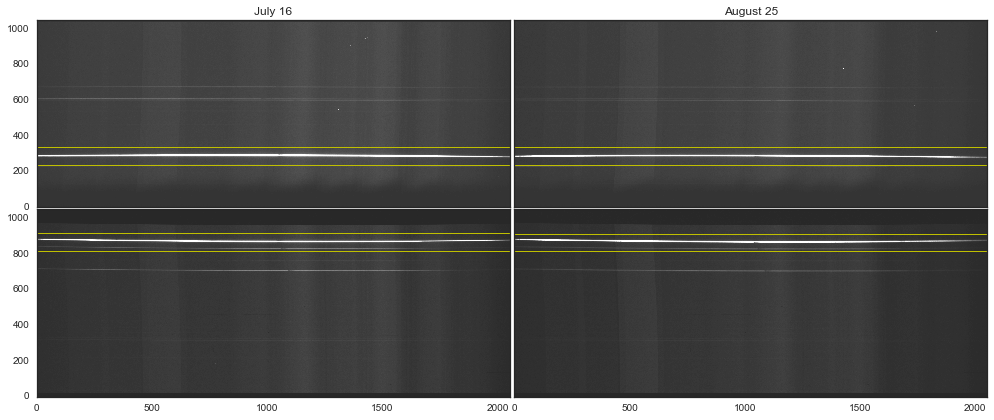

In [13]:
fig,axs = subplots(2,2,figsize=(14,6), sharex=True)
for irun in [0,1]:
    ccd1, ccd2 = [pf.getdata(l_obj[irun][10], iccd) for iccd in [1,2]]
    axs[0,irun].imshow(ccd1.T, cmap=cm.gray, aspect='auto', origin='image', vmin=500, vmax=4000)
    axs[0,irun].axhspan(centers[irun,0]-50, centers[irun,0]+50, fill=False, edgecolor='y', lw=1)
    axs[1,irun].imshow(ccd2.T, cmap=cm.gray, aspect='auto', origin='image', vmin=500, vmax=4000)
    axs[1,irun].axhspan(centers[irun,1]-50, centers[irun,1]+50, fill=False, edgecolor='y', lw=1)
    axs[0,irun].set_title(['July 16','August 25'][irun])
setp(axs[:,1], yticks=[])
setp(axs, ylim=(0,ccd1.shape[1]))
fig.tight_layout()
fig.subplots_adjust(wspace=0.01, hspace=0.01)

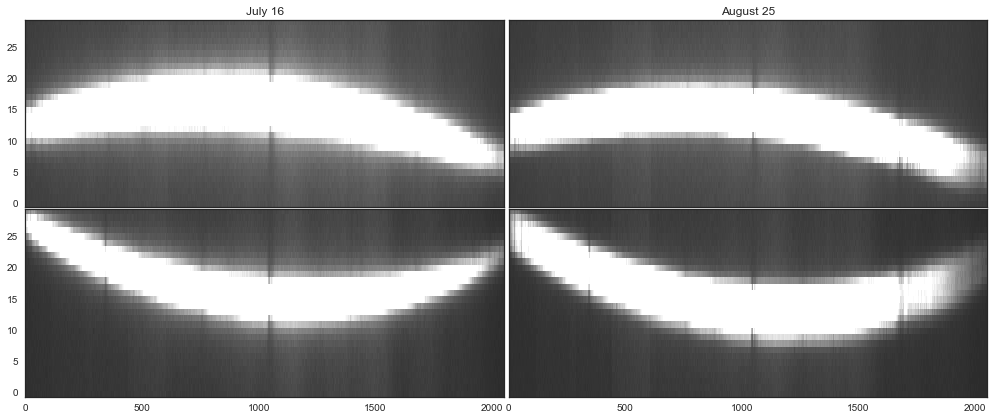

In [238]:
fig,axs = subplots(2,2,figsize=(14,6), sharex=True)
isargs = dict(cmap=cm.gray, aspect='auto', origin='image', vmin=500, vmax=4000)
for irun in [0,1]:
    ccd1, ccd2 = [pf.getdata(l_obj[irun][10], iccd) for iccd in [1,2]]
    axs[0,irun].imshow(ccd1.T[ymins[irun,0]:ymaxs[irun,0]], **isargs)
    axs[1,irun].imshow(ccd2.T[ymins[irun,1]:ymaxs[irun,1]], **isargs)
    axs[0,irun].set_title(['July 16','August 25'][irun])
setp(axs[:,1], yticks=[])
fig.tight_layout()
fig.subplots_adjust(wspace=0.01, hspace=0.01)

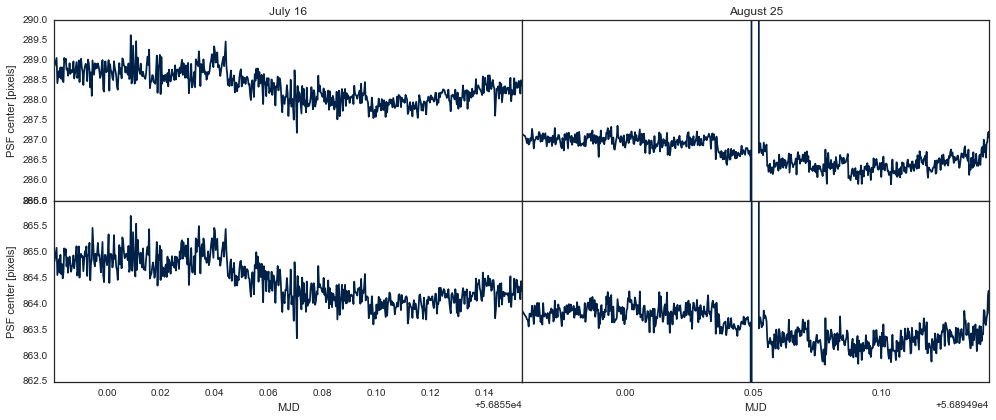

In [222]:
fig,axs = subplots(2,2,figsize=(14,6), sharex=False, sharey=False)
for irun,df in enumerate([jul16,aug25]):
    axs[0,irun].plot(df['mjd-obs'].values, df.center_1.values)
    axs[1,irun].plot(df['mjd-obs'].values, df.center_2.values)
    axs[0,irun].set_title(['July 16','August 25'][irun])
    setp(axs[:,irun], xlim=df['mjd-obs'].values[[0,-1]])
setp(axs[0,:], ylim=(285.5,290))
setp(axs[1,:], ylim=(862.5,866))
setp(axs[:,0], ylabel='PSF center [pixels]')
setp(axs[1,:], xlabel='MJD')
setp(axs[:,1], yticks=[])
fig.tight_layout()
fig.subplots_adjust(wspace=0.0, hspace=0.0)

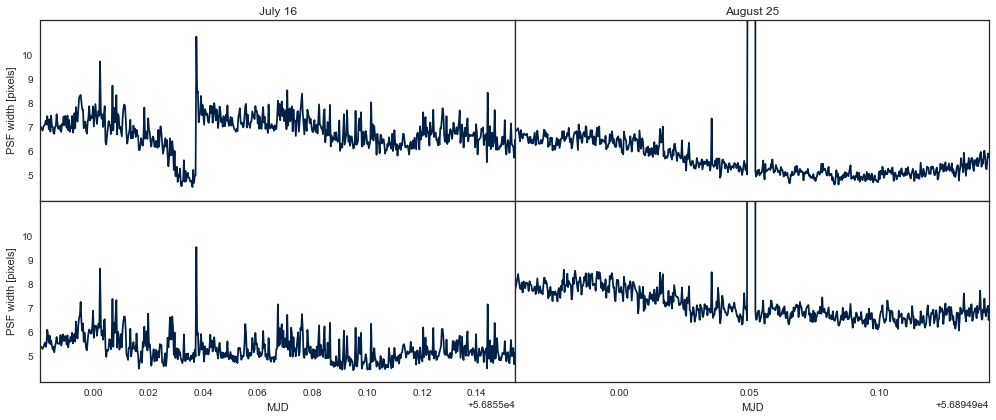

In [221]:
fig,axs = subplots(2,2,figsize=(14,6), sharex=False, sharey=True)
for irun,df in enumerate([jul16,aug25]):
    axs[0,irun].plot(df['mjd-obs'].values, df.width_1.values)
    axs[1,irun].plot(df['mjd-obs'].values, df.width_2.values)
    axs[0,irun].set_title(['July 16','August 25'][irun])
    setp(axs[:,irun], xlim=df['mjd-obs'].values[[0,-1]])
setp(axs, ylim=(4,11.5), yticks=arange(5,11))
setp(axs[:,0], ylabel='PSF width [pixels]')
setp(axs[1,:], xlabel='MJD')
fig.tight_layout()
fig.subplots_adjust(wspace=0.0, hspace=0.0)

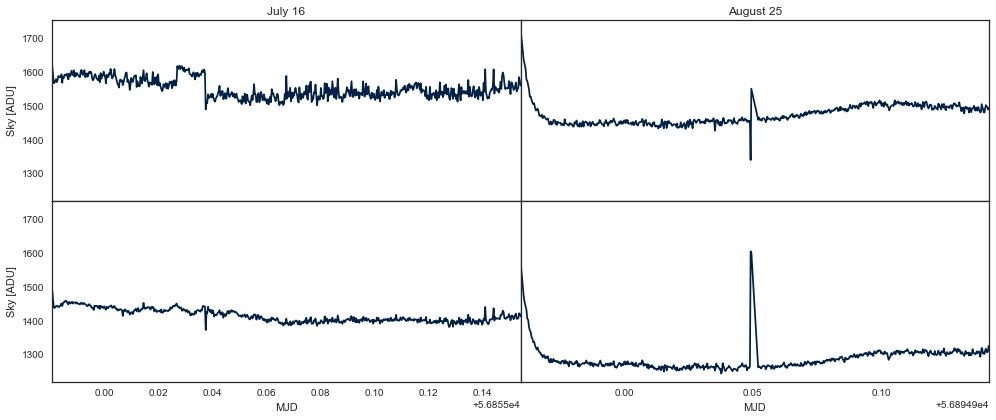

In [220]:
fig,axs = subplots(2,2,figsize=(14,6), sharex=False, sharey=True)
for irun,df in enumerate([jul16,aug25]):
    axs[0,irun].plot(df['mjd-obs'].values, df.sky_1.values)
    axs[1,irun].plot(df['mjd-obs'].values, df.sky_2.values)
    axs[0,irun].set_title(['July 16','August 25'][irun])
    setp(axs[:,irun], xlim=df['mjd-obs'].values[[0,-1]])
setp(axs[:,0], ylabel='Sky [ADU]')
setp(axs[1,:], xlabel='MJD')
fig.tight_layout()
fig.subplots_adjust(wspace=0.0, hspace=0.0)

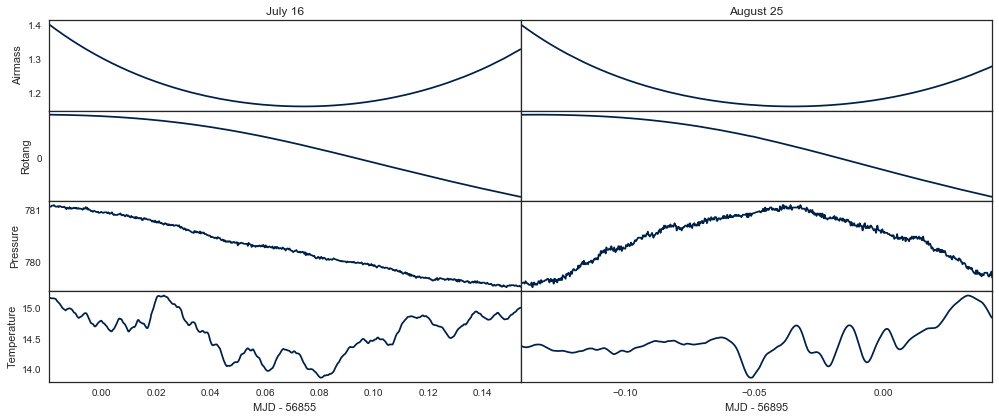

In [232]:
fig,axs = subplots(4,2,figsize=(14,6))
for irun,df in enumerate([jul16,aug25]):
    time = df['mjd-obs'].values.copy()
    t0, time = time[0].round(), time-time[0].round()
    axs[0,irun].plot(time, df.airmass.values)
    axs[1,irun].plot(time, df.rotang.values)
    axs[2,irun].plot(time, df.pressure.values)
    axs[3,irun].plot(time, df.tambient.values)
    axs[0,irun].set_title(['July 16','August 25'][irun])
    setp(axs[-1,irun], xlabel='MJD - {:5.0f}'.format(t0))
    setp(axs[:,irun], xlim=time[[0,-1]])
[a.set_ylabel(l) for a,l in zip(axs[:,0],'Airmass Rotang Pressure Temperature'.split())]
setp(axs[:-1,:], xticks=[])
setp(axs[:,1], yticks=[])
fig.tight_layout()
fig.subplots_adjust(wspace=0.0, hspace=0.0)

---

<center> &copy; 2016 <a href="mailto:hannu.parviainen@physics.ox.ac.uk">Hannu Parviainen</a></center>